### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


# ML utils

In [1]:
# !pip install pytorch-ignite

In [23]:
from math import ceil
from dataclasses import dataclass, field

import pandas as pd
import plotly.express as px
from IPython.display import clear_output
from plotly.subplots import make_subplots


Report = dict[str, float]
@dataclass
class History:
    train: list[Report] = field(default_factory=list)
    val: list[Report] = field(default_factory=list)
    
    def push_epoch(self, train_report: Report, test_report: Report) -> None:
        self.train.append(train_report)
        self.val.append(test_report)
    
    def as_df(self) -> pd.DataFrame:
        # return metrics as one DataFrame with additional epoch and phase (train / test) columns
        # for plotting
        
        return pd.concat(map(pd.DataFrame, [self.train, self.val]),
                         keys=["train", "test"])\
                 .reset_index(names=["phase", "epoch"])
    
    def __len__(self) -> int:
        return len(self.train)
        

def plot_metrics(history: History, metrics_to_plot: list[str], titles: list[str],
                height: int = 600, width: int = 1000, plot_cols: int = 3,
                path: Path | str | None = None):
    
    clear_output(True)
    plot_cols = min(plot_cols, len(metrics_to_plot))
    plot_rows = ceil(len(metrics_to_plot) / plot_cols)
    fig = make_subplots(rows=plot_rows, cols=plot_cols, subplot_titles=titles)
    
    tracer = px.line if len(history) > 1 else px.scatter
    df = history.as_df()
    
    for i, metric in enumerate(metrics_to_plot):
        for trace in tracer(df, x="epoch", y=metric, color="phase")["data"]:
            # delete duplicate legends
            if not i:
                trace.update(showlegend=False)
                
            fig.append_trace(
                trace,
                row=i // plot_cols + 1, col=i % plot_cols + 1
            )
    
    fig.update_layout(height=height, width=width, showlegend=True)
    fig.show()
    
    if path is not None:
        fig.write_image(path)
        fig.write_html(str(path) + ".html")

In [3]:
from sklearn.model_selection import train_test_split

def train_val_test_split(*arrays, test_size: float, val_size: float = 0, **kwargs):
    rets_train_val = train_test_split(*arrays, test_size=test_size + val_size, **kwargs)
    
    test_size_cond = test_size / (test_size + val_size)
    rets_val_test = train_test_split(*rets_train_val[1::2], train_size=test_size_cond, **kwargs)
    
    train, val, test = rets_train_val[::2], rets_val_test[::2], rets_val_test[1::2]
    
    return sum(zip(train, val, test), start=())

# 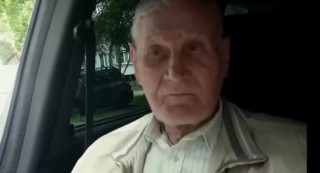

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import map, filter
%matplotlib inline

In [5]:
from collections import Counter

import nltk


data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

############################################################
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')

############################################################
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col]\
        .astype(str)\
        .str.lower()\
        .apply(tokenizer.tokenize)\
        .apply(' '.join)

############################################################
token_counts = Counter([
    word
    for line in data[text_columns].values.flatten()
    for word in line.split()
])

min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = dict(zip(tokens, range(len(tokens))))

In [6]:
import torch
import torch.nn as nn
import torch.functional as F
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage


In [7]:
# top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
# recognized_companies = set(top_companies)

# data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

In [8]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None, min_len=5):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, min_len)
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix


device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_tensors(batch: dict, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int32)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data: pd.DataFrame, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [9]:
from sklearn.model_selection import train_test_split

data_train: pd.DataFrame
data_val: pd.DataFrame
data_train, data_val  = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))


In [10]:
class Apply(nn.Module):
    def __init__(self, func, *func_args, **func_kwargs):
        super().__init__()
        self.func = func
        self.func_args = func_args
        self.func_kwargs = func_kwargs
    
    def forward(self, X):
        return self.func(X, *self.func_args, **self.func_kwargs)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        
        self.encoded_len = 64
        self._hid_size = hid_size
        self.title_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, 64, 3),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.description_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, 64, 5, ),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64)
        )
        outp_features = 64*3
        self.output = nn.Sequential(
            nn.BatchNorm1d(outp_features),
            nn.Linear(outp_features, hid_size),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1),
            Apply(torch.squeeze)
        )
        
    def forward(self, batch: dict[str, torch.TensorType]):
        concat = torch.cat((
            self.title_encoder(batch["Title"]),
            self.description_encoder(batch["FullDescription"]),
            self.cat_encoder(batch["Categorical"])
        ), axis=1)
        return self.output(concat)
    
    def predict(self, batch):
        return torch.exp(self.forward(batch)) + 1

In [11]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [12]:
from tqdm.auto import tqdm

BATCH_SIZE = 256
EPOCHS = 5

def get_metrics(model, data, batch_size=BATCH_SIZE, device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw), total=ceil(len(data) / BATCH_SIZE)):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return {"mse": mse, "mae": mae}

# Model 0

In [12]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
history = History()
epoch = 0

min_mae = np.inf
counter = 0

In [46]:
while True:
    print(f"epoch: {epoch}")
    epoch += 1
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=ceil(len(data_train) / BATCH_SIZE)
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    history.push_epoch(get_metrics(model, data_train, device=device),
                       get_metrics(model, data_val, device=device))

    plot_metrics(history, ["mse", "mae"], ["mse", "mae"])
    
    if history.val[-1]["mae"] < min_mae:
        min_mae = history.val[-1]["mae"]
        counter = 0
        torch.save(model.state_dict(), "./01_base.pt")
    else:
        counter += 1
        if counter == 3:
            break

In [136]:
from tqdm.auto import tqdm

def batch_to_device(batch, device):
    return {key : val.to(device) for key, val in batch.items()}

def get_metrics(model, dataset, device):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataset):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return {"mse": mse, "mae": mae}

def bar(model, train, val, criterion, optimizer, history, name):
    epoch = 1
    min_mae = np.inf
    counter = 0

    while True:
        print(f"epoch: {epoch}")
        epoch += 1
        model.train()
        train.reshuffle()
        for batches in tqdm(train):
            optimizer.zero_grad()
            
            for batch in batches:
                pred = model(batch)
                loss = criterion(pred, batch[TARGET_COLUMN]) / train.subs_in_batch
                loss.backward()
            optimizer.step()
            
        history.push_epoch(get_metrics(model, train.flatten(), device=device),
                           get_metrics(model, val.flatten(), device=device))
        

        plot_metrics(history, ["mse", "mae"], ["mse", "mae"])
        
        if history.val[-1]["mae"] < min_mae:
            min_mae = history.val[-1]["mae"]
            counter = 0
            torch.save(model.state_dict(), f"./{name}.pt")
        else:
            counter += 1
            if counter == 3:
                break

In [11]:
# from torch.utils.data import Dataset
# import numpy as np
# from random import shuffle
# from toolz import curry


# class MyDataset(Dataset):
#     def __init__(self, data: pd.DataFrame, subbatch_size: int, subs_in_batch: int, device: str):
#         super().__init__()
#         self.raw_data = data
#         self.subbatch_size = subbatch_size
#         self.subs_in_batch = subs_in_batch
#         self.subbatches: list[dict[str, torch.tensor]] = None
#         self.device = device
        
#         self._group_by_len()
    
#     def _group_by_len(self) -> None:
        
#         df = self.raw_data\
#                  .assign(descr_len=self.raw_data.FullDescription.str.split().apply(len),
#                          title_len=self.raw_data.Title.str.split().apply(len))\
#                  .sort_values(by=["descr_len", "title_len"])
        
#         subbatches = [df.iloc[i * self.subbatch_size : (i + 1) * self.subbatch_size]
#                       for i in range(ceil(len(self.raw_data) / self.subbatch_size))]
        
#         self.subbatches = map(curry(make_batch, device=self.device), subbatches)

#     def __len__(self):
#         return ceil(len(self.subbatches) / self.subs_in_batch)

#     def __getitem__(self, idx: int):
#         if idx >= len(self):
#             raise IndexError
#         return self.subbatches[idx * self.subs_in_batch : (idx + 1) * self.subs_in_batch]
    
#     def reshuffle(self):
#         shuffle(self.subbatches)
    
#     def flatten(self):
#         return FlattenSubbatches(self.subbatches)
    
#     def size(self):
#         # size in Gb
#         t = sum(sum(map(lambda tensor: tensor.element_size() * tensor.nelement(), subbatch.values()))
#                 for subbatch in self.subbatches)
#         return t / 1024 ** 3

        
        
# class FlattenSubbatches(Dataset):
#     def __init__(self, batches):
#         super().__init__()
#         self.batches = batches
    
#     def __len__(self):
#         return len(self.batches)
    
#     def __getitem__(self, idx: int):
#         if idx >= len(self):
#             raise IndexError
#         return self.batches[idx]

In [12]:
train_dataset = MyDataset(data_train, 64, 4, device)
val_dataset = MyDataset(data_val, 64, 1, device)

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
history = History()

In [16]:
bar(model, train_dataset, val_dataset, criterion, optimizer, history, "t_model")

# Improvement 0

In [ ]:
# print(categorical_vectorizer.transform(data_train[categorical_columns].apply(dict, axis=1)).nbytes / 1024 ** 3, "Gb")
# for col in categorical_columns:
#     print(col, len(data_train[col].unique()), data_train[col].unique()[:10])

2.747890867292881

The most obvious first improvement is to get rid of dense float32 one-hot matrices to decrease overhead / store all data on gpu.

From [here](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html), embeddings of sizes `(num_of_categories)**.25` can be used

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


def get_top_n(X, n):
    top, _ = zip(*Counter(X).most_common(n))
    return top

N = 1000

top_n_ordencoder_template = OrdinalEncoder(
    dtype=np.int32,
    max_categories=N + 1, # all infrequent categories will be transformed into `N`
    handle_unknown="use_encoded_value",
    unknown_value=N
)

simple_cats = ["Category", "ContractType", "ContractTime"]
big_cats = ["Company", "LocationNormalized"]
cat_to_ord = ColumnTransformer([
    ("to_num", OrdinalEncoder(dtype=np.int32), simple_cats),
    ("most_freq_to_num", top_n_ordencoder_template, big_cats)
]).fit(data_train)

_ord_for_simple = cat_to_ord.transformers_[0][1]
vocab_sizes = dict(zip(simple_cats, map(len, _ord_for_simple.categories_)))
vocab_sizes |= dict(zip(big_cats, [N + 1] * 2))
vocab_sizes

{'Category': 29,
 'ContractType': 3,
 'ContractTime': 3,
 'Company': 1001,
 'LocationNormalized': 1001}

In [14]:
from torch.utils.data import Dataset, DataLoader
from toolz import curry


def seq_to_tensor(words, max_len, device):
    return torch.tensor(
        [token_to_id.get(word, UNK_IX) for word in words[:max_len]],
        device=device
    )
        

class MyDataset(Dataset):
    def __init__(self, data: pd.DataFrame, device: str, max_len=None, is_train=True):
        super().__init__()
        
        data_dict = {}
        for col in ["FullDescription", "Title"]:
            data_dict[col] = data[col]\
                .str.split()\
                .apply(curry(seq_to_tensor, max_len=max_len, device=device))\
                .to_list()
        
        data_dict["Categorical"] = torch.tensor(cat_to_ord.transform(data), device=device)
        data_dict[TARGET_COLUMN] = torch.tensor(data[TARGET_COLUMN].values, device=device)
        
        self.data = list(zip(*data_dict.values()))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        return self.data[idx]

def collate_fn(dataset_entries, min_len=5):
    full_descrs, titles, cats, targets = zip(*dataset_entries)
    size = len(dataset_entries)
    device = targets[0].device
    
    cat_raw = torch.vstack(cats)
    cat_raw[:, 1:] += torch.tensor(list(vocab_sizes.values()), device=device)[:-1]

    cat = torch.zeros((size, sum(vocab_sizes.values())), device=device)
    cat[torch.tensor(np.arange(size).repeat(5)), cat_raw.flatten()] = 1.
    
    rets = {"Categorical": cat, TARGET_COLUMN: torch.stack(targets)}
    
    for name, sequences in ("FullDescription", full_descrs), ("Title", titles):
        matrix = torch.nn.utils.rnn.pad_sequence(
            sequences, 
            batch_first=True, padding_value=PAD_IX
        )
        if matrix.shape[1] < min_len:
            matrix = torch.hstack(
                matrix, 
                torch.full((matrix.shape[0], min_len - matrix.shape[1]), PAD_IX)
            )
            
        rets[name] = matrix
    
    return rets

def get_dataloader(data, batch_size, device=device):
    return DataLoader(
        MyDataset(data, device),
        batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )

In [15]:
from pathlib import Path

def get_metrics(model, dataset):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataset):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return {"mse": mse, "mae": mae}

def do_model(model, train, val, criterion, optimizer, scheduler, history: History, name, patience = 5):
    epoch = 1
    min_mae = np.inf
    counter = 0

    while True:
        print(f"epoch: {epoch}")
        epoch += 1
        model.train()
        for batch in tqdm(train):
            pred = model(batch)
            loss = criterion(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        history.push_epoch(get_metrics(model, train),
                           get_metrics(model, val))
        scheduler.step(history.val[-1]["mae"])
        
        dir_ = Path("./plots")
        if not dir_.exists():
            dir_.mkdir()
        plot_metrics(history, ["mse", "mae"], ["mse", "mae"], path=dir_/(name + ".png"))
        
        if history.val[-1]["mae"] < min_mae:
            min_mae = history.val[-1]["mae"]
            counter = 0
            torch.save(model.state_dict(), f"./{name}.pt")
        else:
            counter += 1
            if counter >= patience:
                break

In [16]:
class SalaryPredictorNoOHE(SalaryPredictor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cat_embed = [nn.Embedding(vocab_size, max(2, ceil(vocab_size ** .5)))
                          for vocab_size in vocab_sizes.values()]
        
        for col, embed in zip(vocab_sizes.keys(), self.cat_embed):
            setattr(self, f"{col}_embed", embed)
        
        # change input size
        self.output[0] = nn.LazyBatchNorm1d()
        self.output[1] = nn.LazyLinear(self._hid_size)
        print(128 + sum(vocab_sizes.values()))
    
    def forward(self, batch: dict[str, torch.TensorType]):
        cats = torch.hstack([torch.squeeze(embedder(feature), dim=1) 
                             for embedder, feature in zip(self.cat_embed, batch["Categorical"].T)])
        
        concat = torch.cat((
            self.title_encoder(batch["Title"]),
            self.description_encoder(batch["FullDescription"]),
            cats
        ), axis=1)
        
        return self.output(concat)

In [17]:
train_dataset = get_dataloader(data_train, 256)
val_dataset = get_dataloader(data_val, 512)

In [25]:
model = SalaryPredictor(n_cat_features=sum(vocab_sizes.values())).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
history = History()

do_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler, history, "03_simple_full_gpu")

In [18]:
train_dataset = get_dataloader(data_train, 256)
val_dataset = get_dataloader(data_val, 512)

model = SalaryPredictorNoOHE().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
history = History()

do_model(model, train_dataset, val_dataset, criterion, optimizer, history, "02_no_ohe")

epoch: 37


  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [88]:
t = next(iter(
    DataLoader(
        MyDataset(data_train[:10], 'cpu'),
        batch_size=5, shuffle=True, collate_fn=collate_fn
    )
))

In [78]:
np.array([1, 2, 3])[None, :]

array([[1, 2, 3]])

In [81]:
nn.Embedding(6, 2)(torch.tensor([1, 2, 3, 4, 5])[:, None]).shape

torch.Size([5, 1, 2])

In [40]:
cat_to_ord.transform(data_train[:10])

array([[  11,    0,    2, 1000,  856],
       [  24,    0,    2,  816,  642],
       [   8,    0,    2, 1000,  840],
       [  13,    0,    2,  295,  547],
       [  15,    1,    0, 1000,  119],
       [  18,    0,    1,  185,  400],
       [  12,    0,    0,  165,  300],
       [  15,    1,    0,  609,  571],
       [  13,    0,    2, 1000, 1000],
       [   5,    0,    2, 1000,  314]], dtype=int32)

In [37]:
top_n_ordencoder.fit(data_train[["Company", "LocationNormalized"]])

OrdinalEncoder(dtype=<class 'numpy.int32'>, handle_unknown='use_encoded_value',
               max_categories=1001, unknown_value=1000)

In [38]:
top_n_ordencoder.categories_

[array(['.Michael Page Financial Services.', '1 1 Recruitment',
        '1 1 Recruitment Limited', ..., 'www.hydrock.com', 'xPO',
        'yourSanctuary'], dtype=object),
 array(['Abbey Village', 'Abbey Wood', 'Abbots Langley', ..., 'Yetminster',
        'York', 'Yorkshire and Humberside'], dtype=object)]

In [32]:
cat_to_ord.transformers[0][1]

OrdinalEncoder(dtype=<class 'numpy.int32'>)

In [40]:
t["Categorical"]

tensor([[  15,    1,    0, 1000,  244],
        [  11,    0,    2, 1000,  136],
        [  18,    0,    1,  596,   15],
        [   8,    0,    2, 1000,    9],
        [  13,    0,    2,  688,    1]], device='cuda:0', dtype=torch.int32)

In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
history = History()
epoch = 0

min_mae = np.inf
counter = 0

In [ ]:
do_model(model, train, val, criterion, optimizer, history, "02_no_ohe")

# Ideas

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!